In [51]:
from collections import OrderedDict
from itertools import combinations
import matplotlib.pyplot as plt
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import pickle
import os

In [99]:
with open("../variable_parameters.pickle", "rb") as f:
    variable_params = pickle.load(f)

In [100]:
problem = {
    'num_vars': 3,
    'names': ['forager_royal_ratio', 'growth_factor', "resource_variability"],
    'bounds': [[0.0, 1.0], [0.0, 1.0], [0.0, 0.5]]
}

In [101]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

                            ST   ST_conf
forager_royal_ratio   0.665781  0.071296
growth_factor         0.730533  0.069820
resource_variability  0.985793  0.077168
                            S1   S1_conf
forager_royal_ratio  -0.144490  0.072441
growth_factor         0.051553  0.090104
resource_variability  0.123323  0.085062


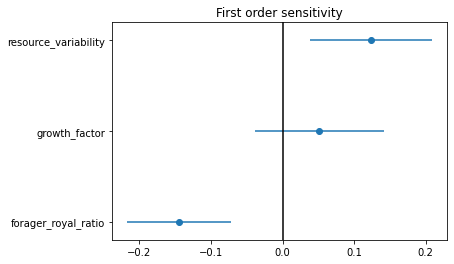

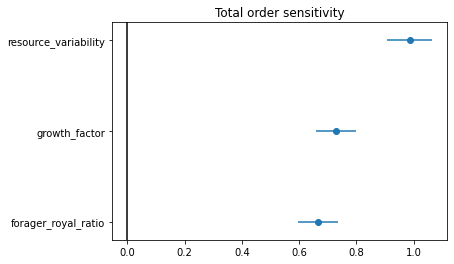

In [106]:
combined = OrderedDict()
for item in variable_params:
    key = (item["forager_royal_ratio"], item["growth_factor"], item["resource_variability"])
    combined[key] = []    

for file in os.listdir():
    if "data_" in file and ".pickle" in file:
        with open(file, "rb") as f:
            data = pickle.load(f)
        for key, row in data.items():
            parameters = (key[0], key[1], key[2])
            if parameters in combined:
                combined[parameters].append(row)
            else:
                combined[parameters] = row

aggregated = {"forager_royal_ratio":[], "growth_factor":[], 
              "resource_variability":[], "Total Fertilized Queens":[]}

for key, rows in combined.items():
    for row in rows:
        aggregated["forager_royal_ratio"].append(key[0])
        aggregated["growth_factor"].append(key[1])
        aggregated["resource_variability"].append(key[2])
        aggregated["Total Fertilized Queens"].append(row["Total Fertilized Queens"][0])

final_dataframe = pd.DataFrame.from_dict(aggregated)

Si = sobol.analyze(problem, np.array(final_dataframe['Total Fertilized Queens']), 
                                     print_to_console=True, calc_second_order=False)

plot_index(Si, problem['names'], '1', 'First order sensitivity')
plt.show()
plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
plt.show()